In [1]:
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pymc as pm
import scipy.stats as stats
import helpsk as hlp

import source.pymc_helpers as ph

%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Data

In [2]:
d = pd.read_csv("/code/data/Howell1.csv", sep=";", header=0)
print(len(d))
d.head()

544


,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


In [3]:
hlp.pandas.numeric_summary(d)

,# of Non-Nulls,# of Nulls,% Nulls,# of Zeros,% Zeros,Mean,St Dev.,Coef of Var,Skewness,Kurtosis,Min,10%,25%,50%,75%,90%,Max
height,544,0,0.0%,0,0.0%,138.3,27.6,0.2,-1.3,0.6,54.0,91.4,125.1,148.6,157.5,162.6,179.1
weight,544,0,0.0%,0,0.0%,35.6,14.7,0.4,-0.5,-0.9,4.2,12.5,22.0,40.1,47.2,51.6,63.0
age,544,0,0.0%,11,2.0%,29.3,20.8,0.7,0.5,-0.5,0.0,3.0,12.0,27.0,43.0,58.0,88.0
male,544,0,0.0%,287,53.0%,0.5,0.5,1.1,0.1,-2.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0


---

# Model

In [4]:
d2 = d[d.age >= 18]

x_bar = d2.weight.mean()
with pm.Model() as m4_3b:
    # this is so we can update the data to make out of sample predictions
    X = pm.MutableData("X", d2.weight.values)
    y = pm.MutableData("y", d2.height.values)

    a = pm.Normal("a", mu=178, sigma=20)
    b = pm.Normal("b", mu=0, sigma=1)
    sigma = pm.Uniform("sigma", 0, 50)
    # mu = a + np.exp(b) * (d2.weight.values - xbar)
    # mu = a + np.exp(b) * (np.zeros(len(d2)) - d2.weight.mean())
    mu = a + b * (X - x_bar)
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=y)
    # trace_4_3b = pm.sample(1000, tune=1000)
    idata_prior = pm.sample_prior_predictive(samples=100, random_seed=RANDOM_SEED)

Sampling: [a, b, height, sigma]


# Prior Checks

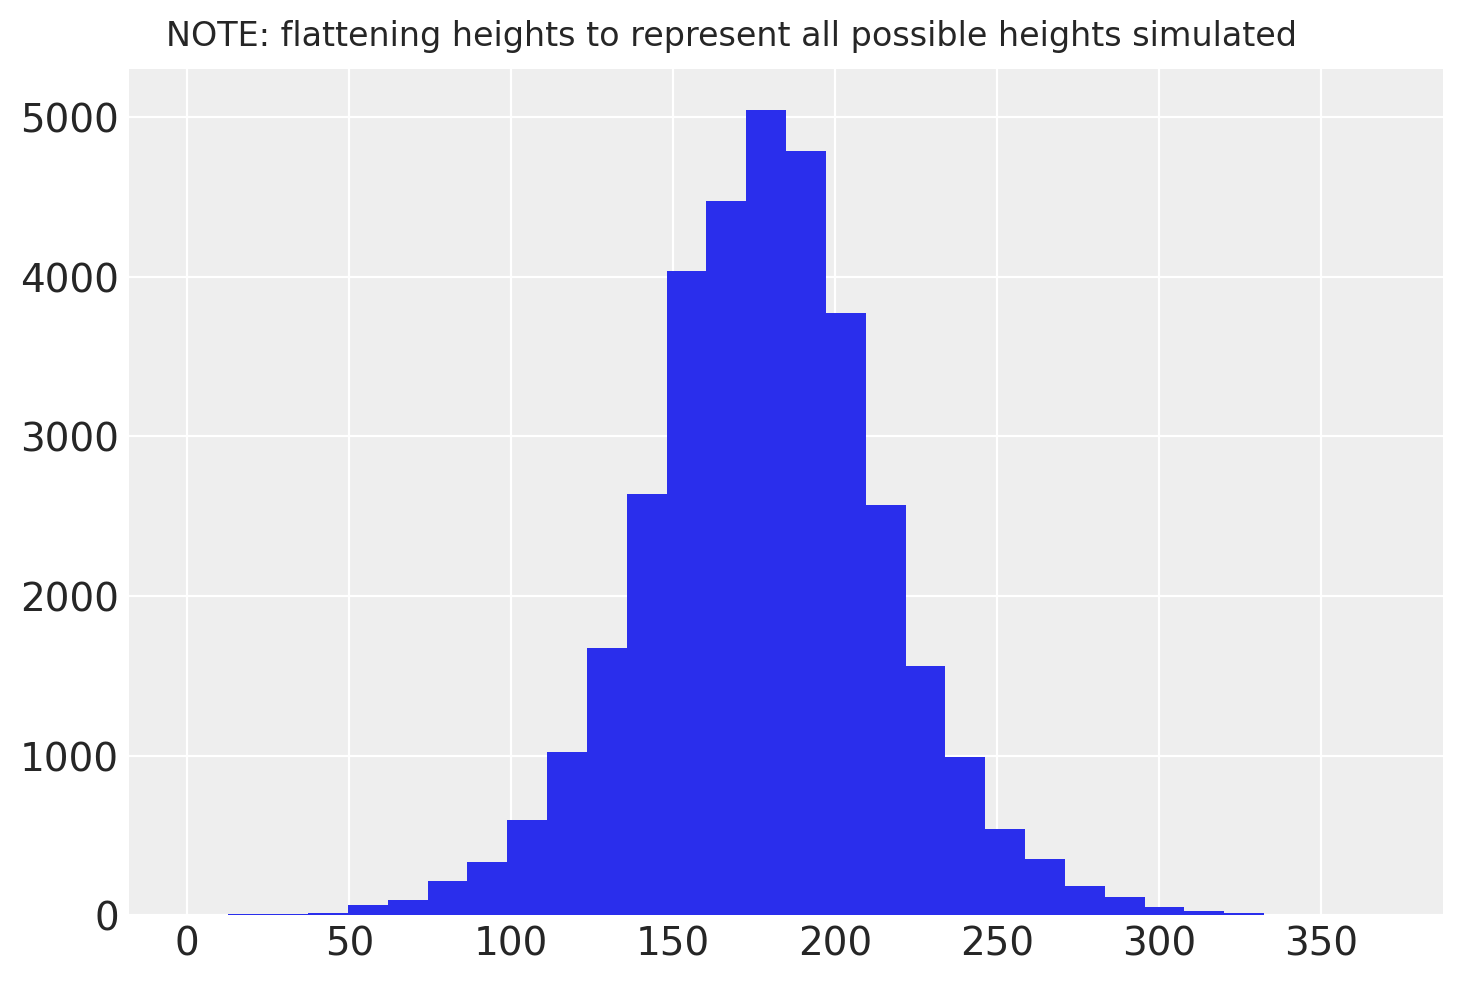

In [5]:
plt.hist(ph.get_prior_samples(idata_prior).flatten(), bins=30)
plt.suptitle('NOTE: flattening heights to represent all possible heights simulated');

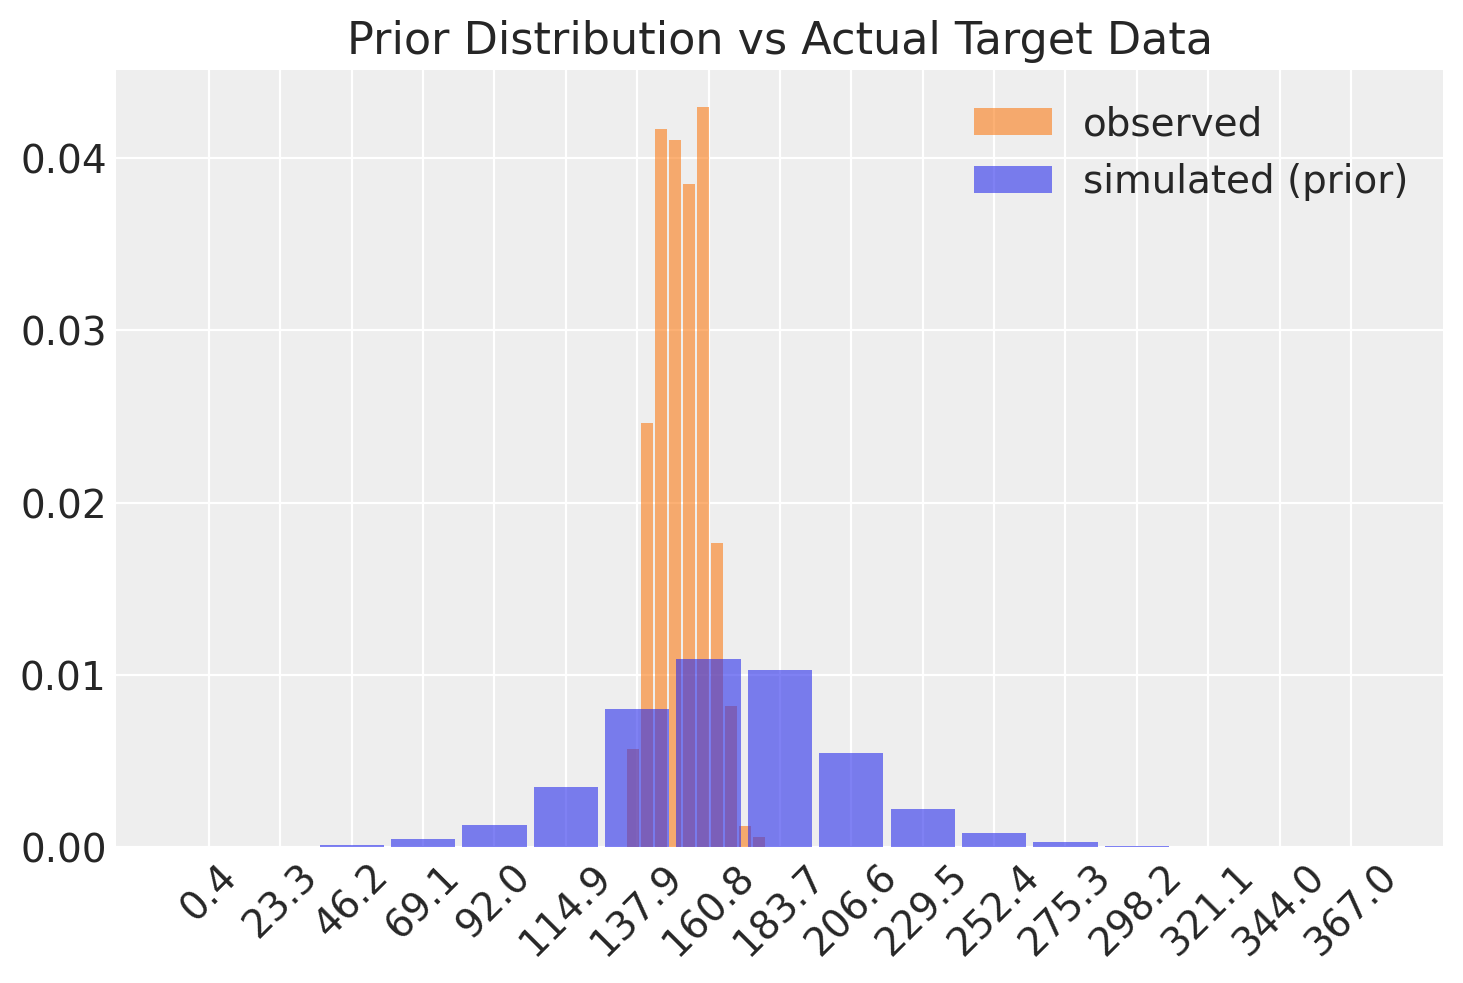

In [6]:
az.plot_dist(
    d2['height'],
    kind="hist",
    color="C1",
    hist_kwargs=dict(alpha=0.6),
    label="observed",
)
az.plot_dist(
    idata_prior.prior_predictive["height"],
    kind="hist",
    hist_kwargs=dict(alpha=0.6),
    label="simulated (prior)",
)
plt.xticks(rotation=45)
plt.title('Prior Distribution vs Actual Target Data');

# Posterior

In [7]:
with m4_3b:
    # Train model
    idata_posterior = pm.sample(draws=1000, tune=1000)
    # Get samples from the posterior (predictions i.e. associated with the observed data)
    idata_predictive = pm.sample_posterior_predictive(
        idata_posterior,
        random_seed=RANDOM_SEED
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Sampling: [height]


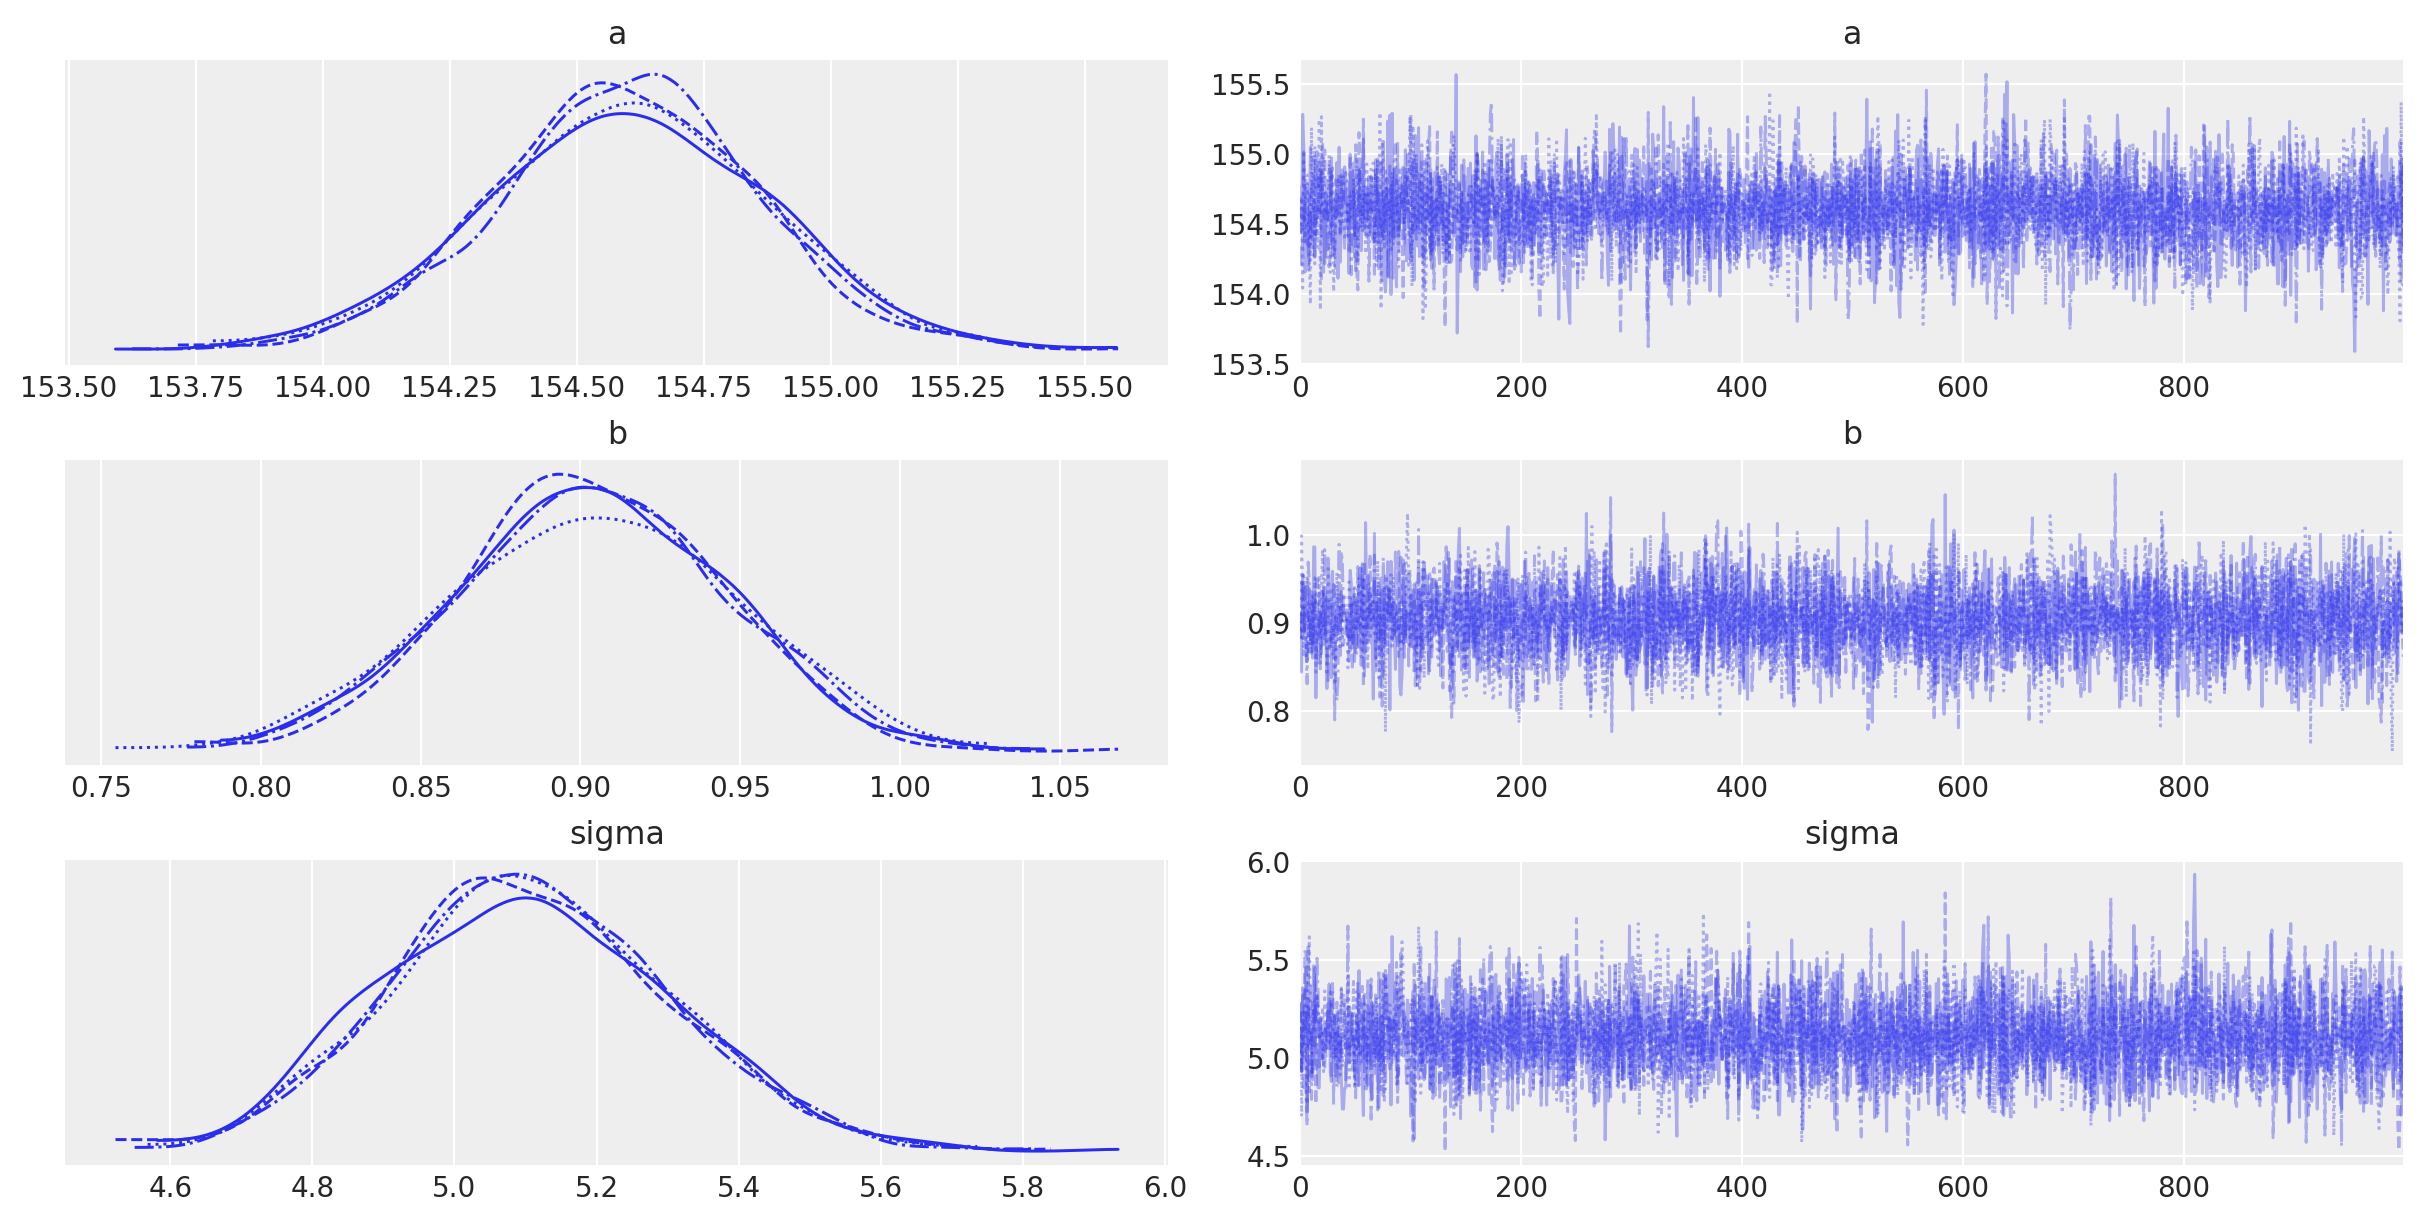

In [8]:
az.plot_trace(idata_posterior);

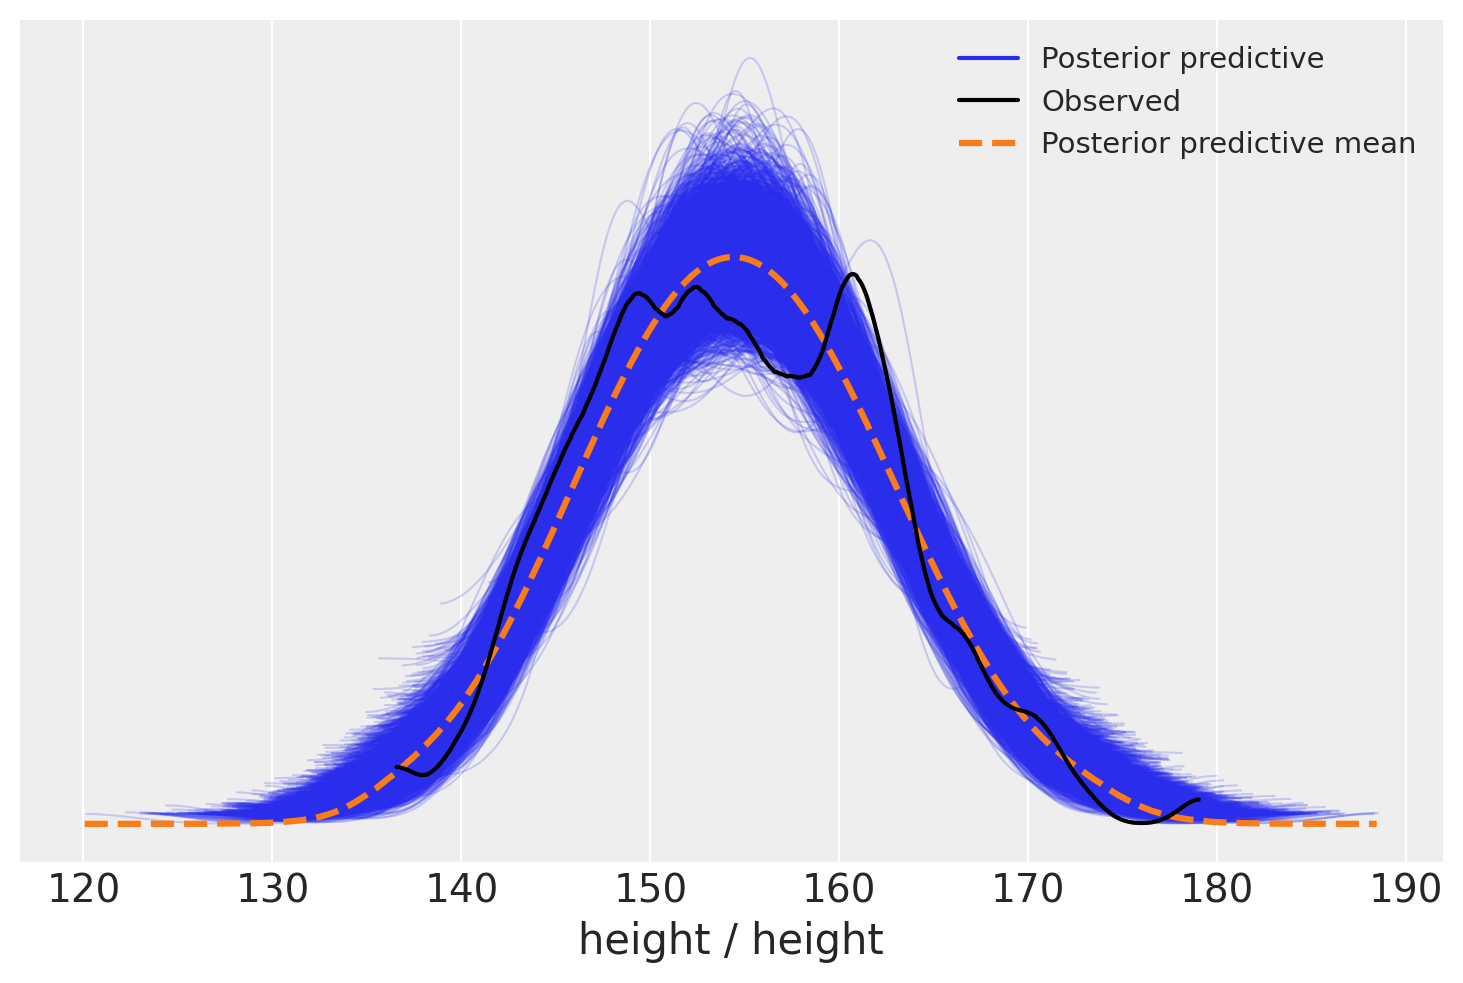

In [9]:
az.plot_ppc(idata_predictive);

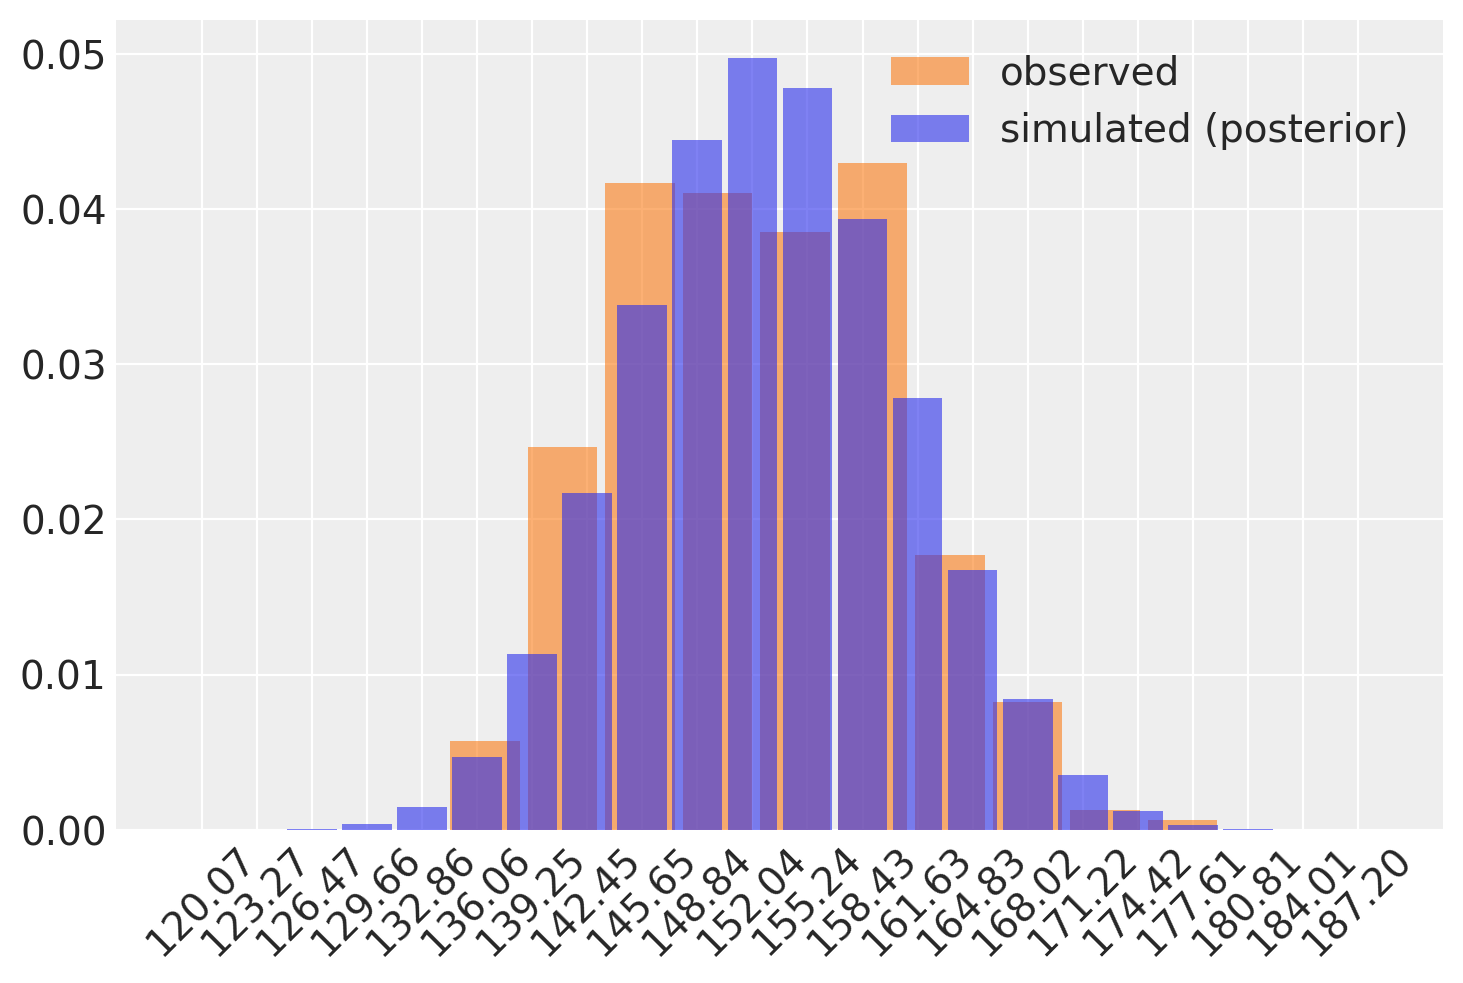

In [10]:

az.plot_dist(
    d2['height'],
    kind="hist",
    color="C1",
    hist_kwargs=dict(alpha=0.6),
    label="observed",
)
az.plot_dist(
    idata_predictive.posterior_predictive["height"],
    kind="hist",
    hist_kwargs=dict(alpha=0.6),
    label="simulated (posterior)",
)
plt.xticks(rotation=45);

In [11]:
prediction_simulations = ph.get_posterior_samples(idata_predictive)
prediction_simulations.shape

(352, 4000)

In [12]:
print(prediction_simulations.min().min())
print(prediction_simulations.max().max())

120.07478136096357
188.56337113120125


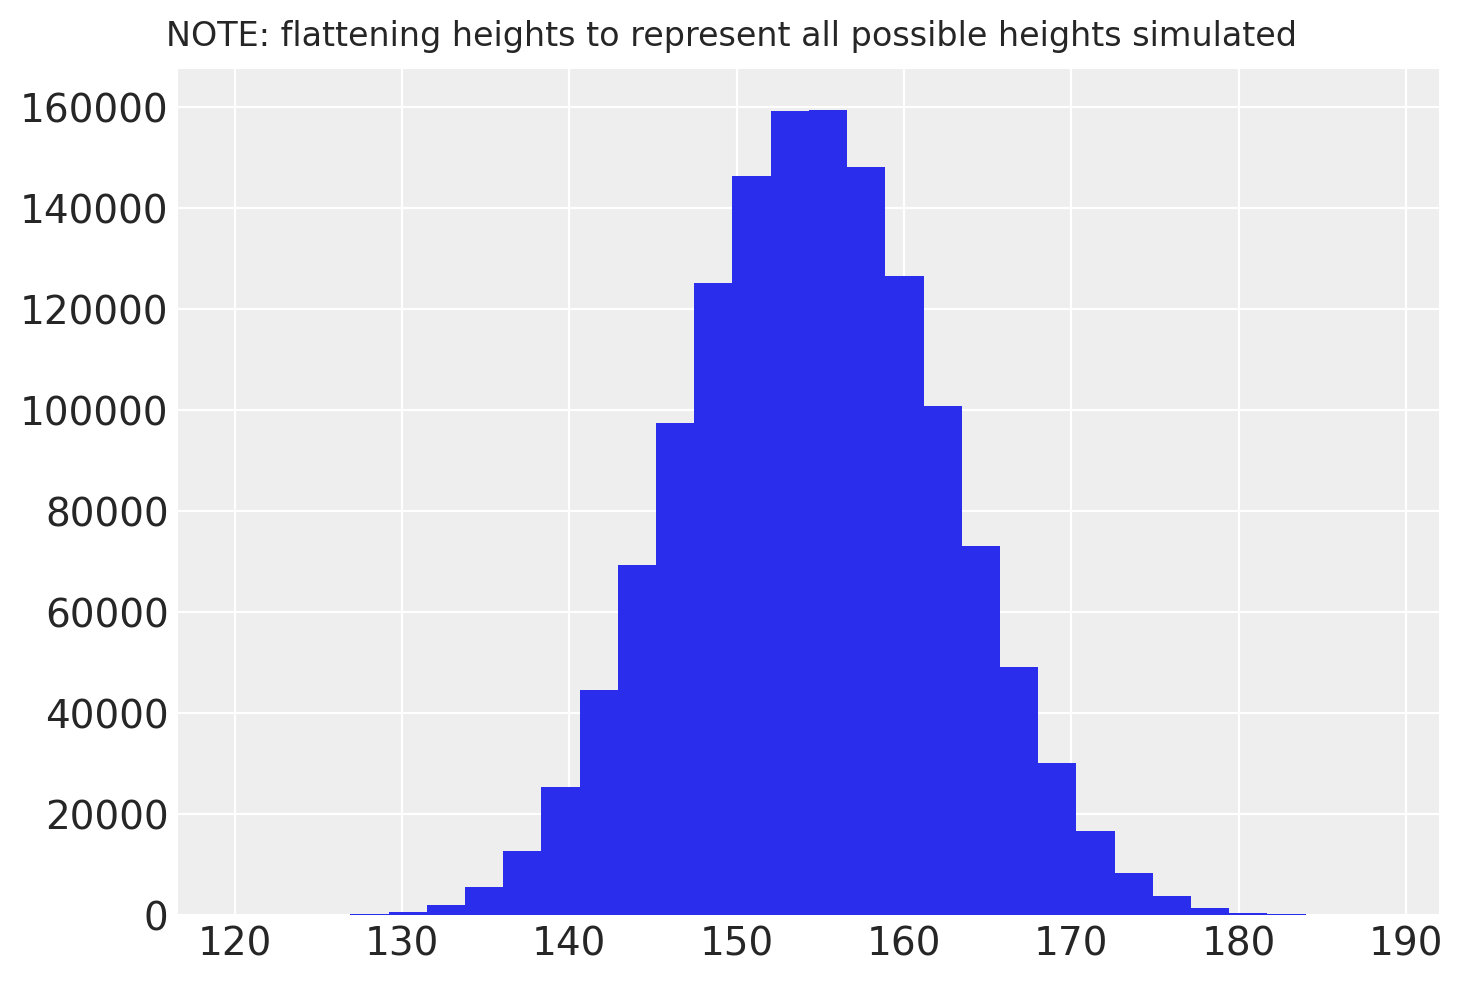

In [13]:
plt.hist(prediction_simulations.flatten(), bins=30)
plt.suptitle('NOTE: flattening heights to represent all possible heights simulated');

Each height is associated with `4000` simulated values. Now get the median/expected value and plot histogram of median values just to see the difference.

In [14]:
print(np.median(prediction_simulations, axis=1).min())
print(np.median(prediction_simulations, axis=1).max())

142.17122673068457
170.83910500696464


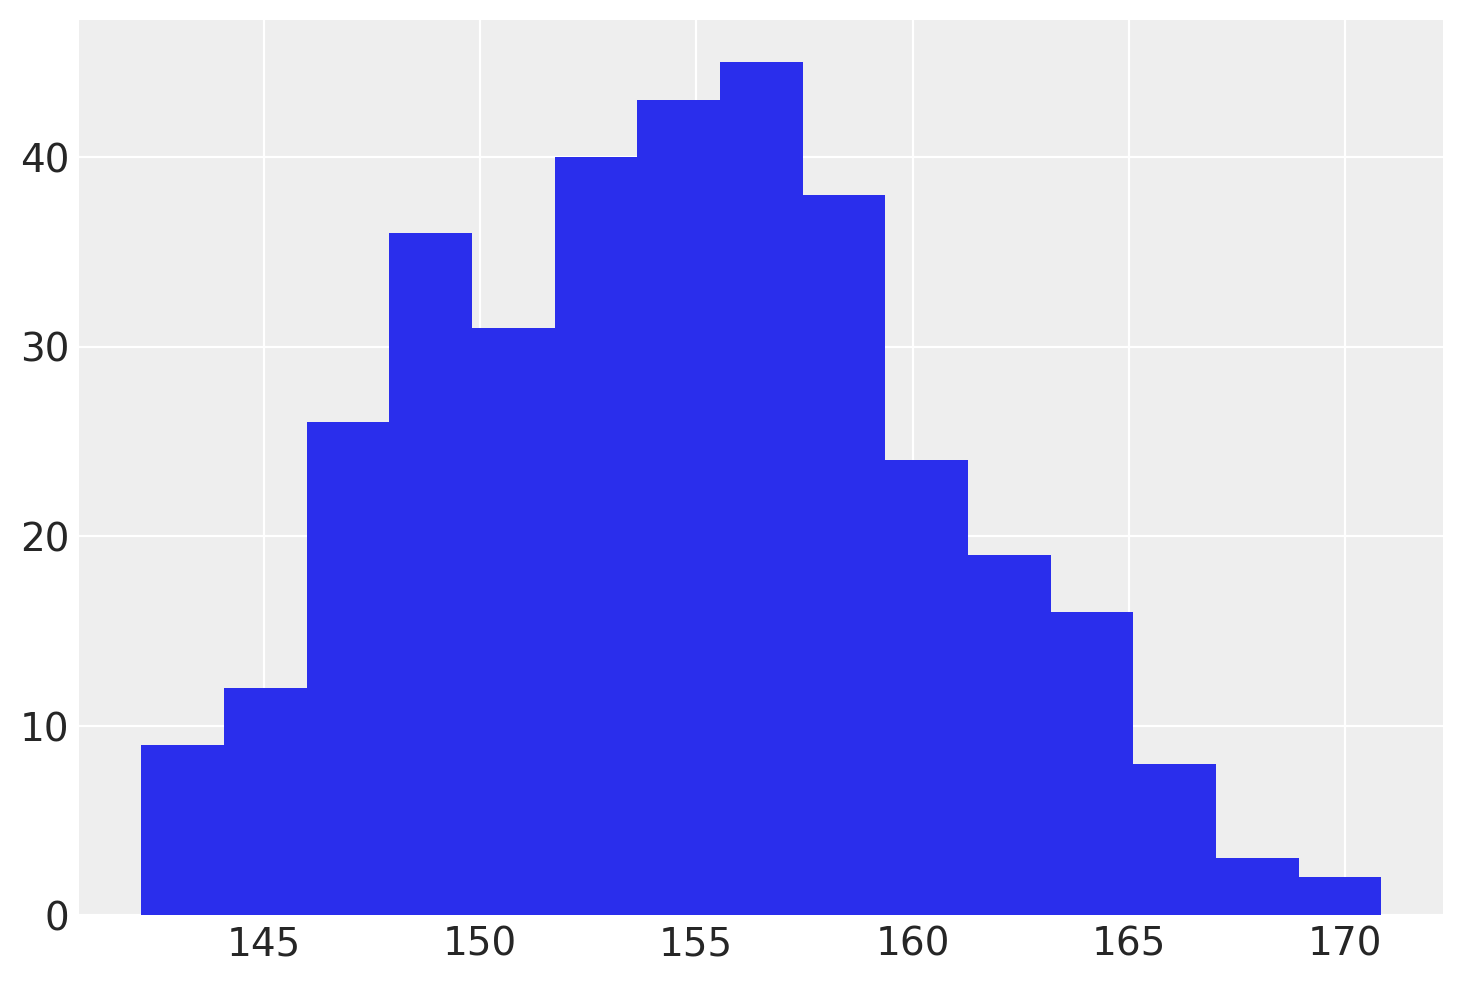

In [15]:
plt.hist(np.median(prediction_simulations, axis=1), bins=15);

In [16]:
az.summary(idata_posterior, kind="stats")

,mean,sd,hdi_3%,hdi_97%
a,154.598,0.272,154.064,155.091
b,0.903,0.042,0.827,0.983
sigma,5.106,0.195,4.758,5.477


In [17]:
az.summary(idata_predictive, kind="stats")

/usr/local/lib/python3.10/site-packages/arviz/stats/stats.py:1351: UserWarning: Selecting first found group: posterior_predictive
  warnings.warn(f"Selecting first found group: {data.groups()[0]}")


,mean,sd,hdi_3%,hdi_97%
height[0],157.247,5.108,147.861,167.178
height[1],146.821,5.147,137.132,156.356
height[2],142.759,5.228,133.371,152.677
height[3],161.994,5.145,152.096,171.289
height[4],151.141,5.102,141.874,161.025
...,...,...,...,...
height[347],156.419,5.010,147.183,165.795
height[348],144.982,5.190,135.086,154.638
height[349],161.093,5.005,151.351,169.935
height[350],162.838,5.015,153.255,172.008


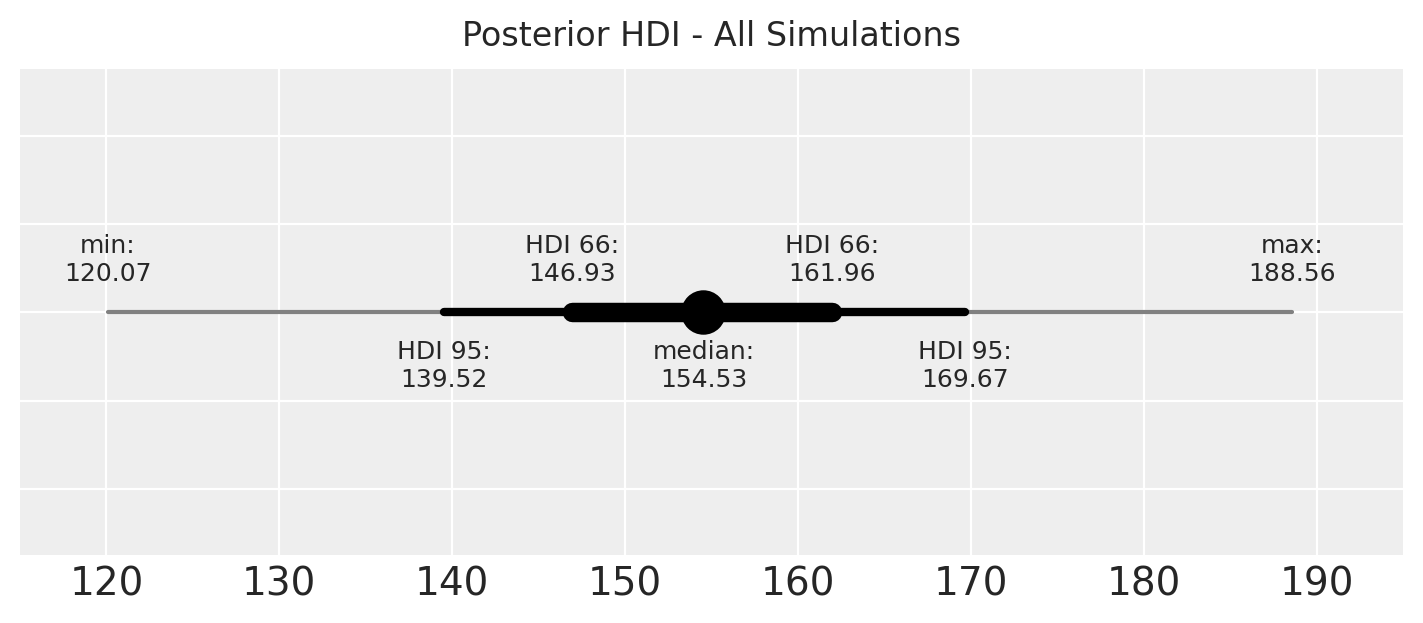

In [18]:
from helpsk.string import format_number

posterior_target_samples = ph.get_posterior_samples(idata_predictive).flatten()

sim_min, sim_median, sim_max = np.quantile(posterior_target_samples, q=[0, 0.5, 1])
sim_95_hdi_prob_low, sim_95_hdi_prob_hi = az.hdi(posterior_target_samples, hdi_prob=0.95)
sim_66_hdi_prob_low, sim_66_hdi_prob_hi = az.hdi(posterior_target_samples, hdi_prob=0.66)

def plot_text(x, label, above=True):
    y = 0.012
    if not above:
        y *= -1
    return plt.text(x=x, y=y, s=f"{label}:\n{format_number(x)}", ha='center', va='center', fontsize=9)

fig, ax = plt.subplots(1)
plt.plot([sim_min, sim_max], [0, 0], color='gray')
plt.plot([sim_95_hdi_prob_low, sim_95_hdi_prob_hi], [0, 0], color='black', linewidth=3)
plt.plot([sim_66_hdi_prob_low, sim_66_hdi_prob_hi], [0, 0], color='black', linewidth=7)
plt.plot(sim_median, 0, 'o', markersize=15, color='black')
ax.set_yticklabels([])
plot_text(x=sim_min, label='min')
plot_text(x=sim_max, label="max")
plot_text(x=sim_median, label="median", above=False)
plot_text(x=sim_66_hdi_prob_low, label="HDI 66")
plot_text(x=sim_66_hdi_prob_hi, label="HDI 66")
plot_text(x=sim_95_hdi_prob_low, label="HDI 95", above=False)
plot_text(x=sim_95_hdi_prob_hi, label="HDI 95", above=False)
fig.set_size_inches(w=7, h=3)
plt.xlim((115, 195))
plt.suptitle("Posterior HDI - All Simulations");

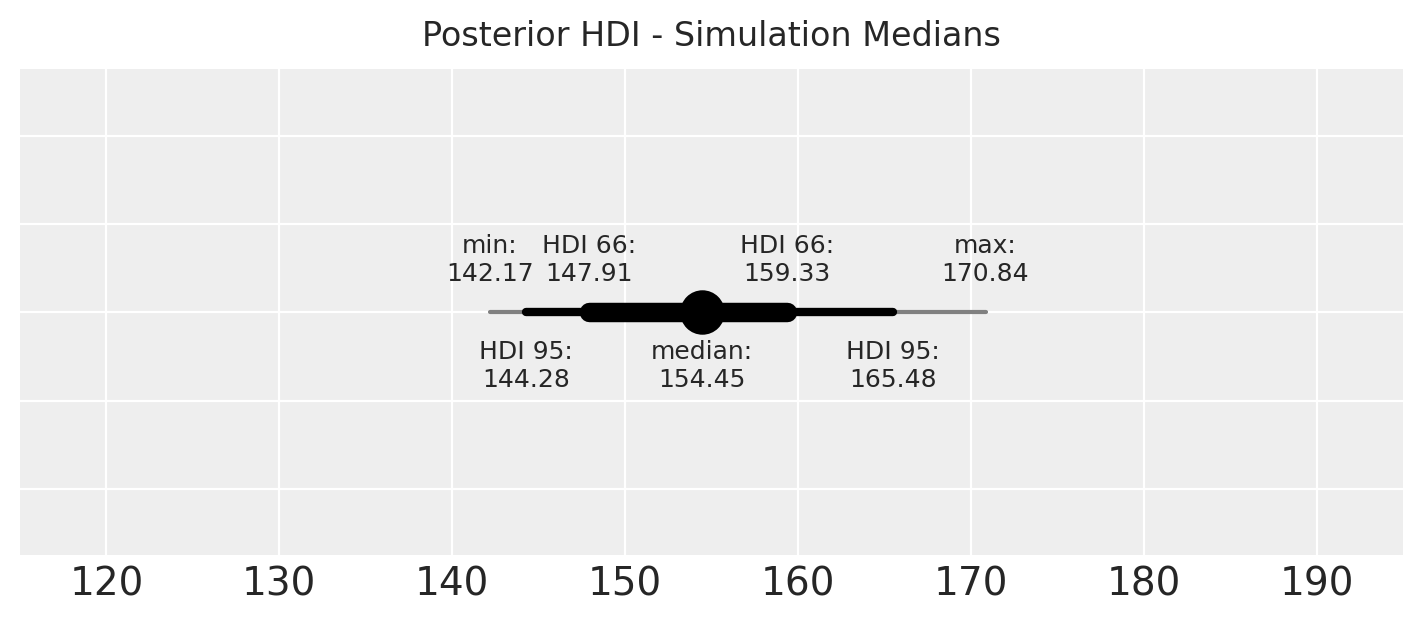

In [19]:
from helpsk.string import format_number

posterior_target_samples = np.median(ph.get_posterior_samples(idata_predictive), axis=1)

sim_min, sim_median, sim_max = np.quantile(posterior_target_samples, q=[0, 0.5, 1])
sim_95_hdi_prob_low, sim_95_hdi_prob_hi = az.hdi(posterior_target_samples, hdi_prob=0.95)
sim_66_hdi_prob_low, sim_66_hdi_prob_hi = az.hdi(posterior_target_samples, hdi_prob=0.66)

def plot_text(x, label, above=True):
    y = 0.012
    if not above:
        y *= -1
    return plt.text(x=x, y=y, s=f"{label}:\n{format_number(x)}", ha='center', va='center', fontsize=9)

fig, ax = plt.subplots(1)
plt.plot([sim_min, sim_max], [0, 0], color='gray')
plt.plot([sim_95_hdi_prob_low, sim_95_hdi_prob_hi], [0, 0], color='black', linewidth=3)
plt.plot([sim_66_hdi_prob_low, sim_66_hdi_prob_hi], [0, 0], color='black', linewidth=7)
plt.plot(sim_median, 0, 'o', markersize=15, color='black')
ax.set_yticklabels([])
plot_text(x=sim_min, label='min')
plot_text(x=sim_max, label="max")
plot_text(x=sim_median, label="median", above=False)
plot_text(x=sim_66_hdi_prob_low, label="HDI 66")
plot_text(x=sim_66_hdi_prob_hi, label="HDI 66")
plot_text(x=sim_95_hdi_prob_low, label="HDI 95", above=False)
plot_text(x=sim_95_hdi_prob_hi, label="HDI 95", above=False)
plt.xlim((115, 195))
fig.set_size_inches(w=7, h=3)
plt.suptitle("Posterior HDI - Simulation Medians");

# New Predictions

In [20]:
x = np.arange(30, 64)
prediction_sims = ph.posterior_predict(
    model=m4_3b,
    idata_posterior=idata_posterior,
    data=x
)
prediction_sims.shape

Sampling: [height]


(34, 4000)

Text(0.5, 0.98, 'Predictions/Simulations vs Actual')

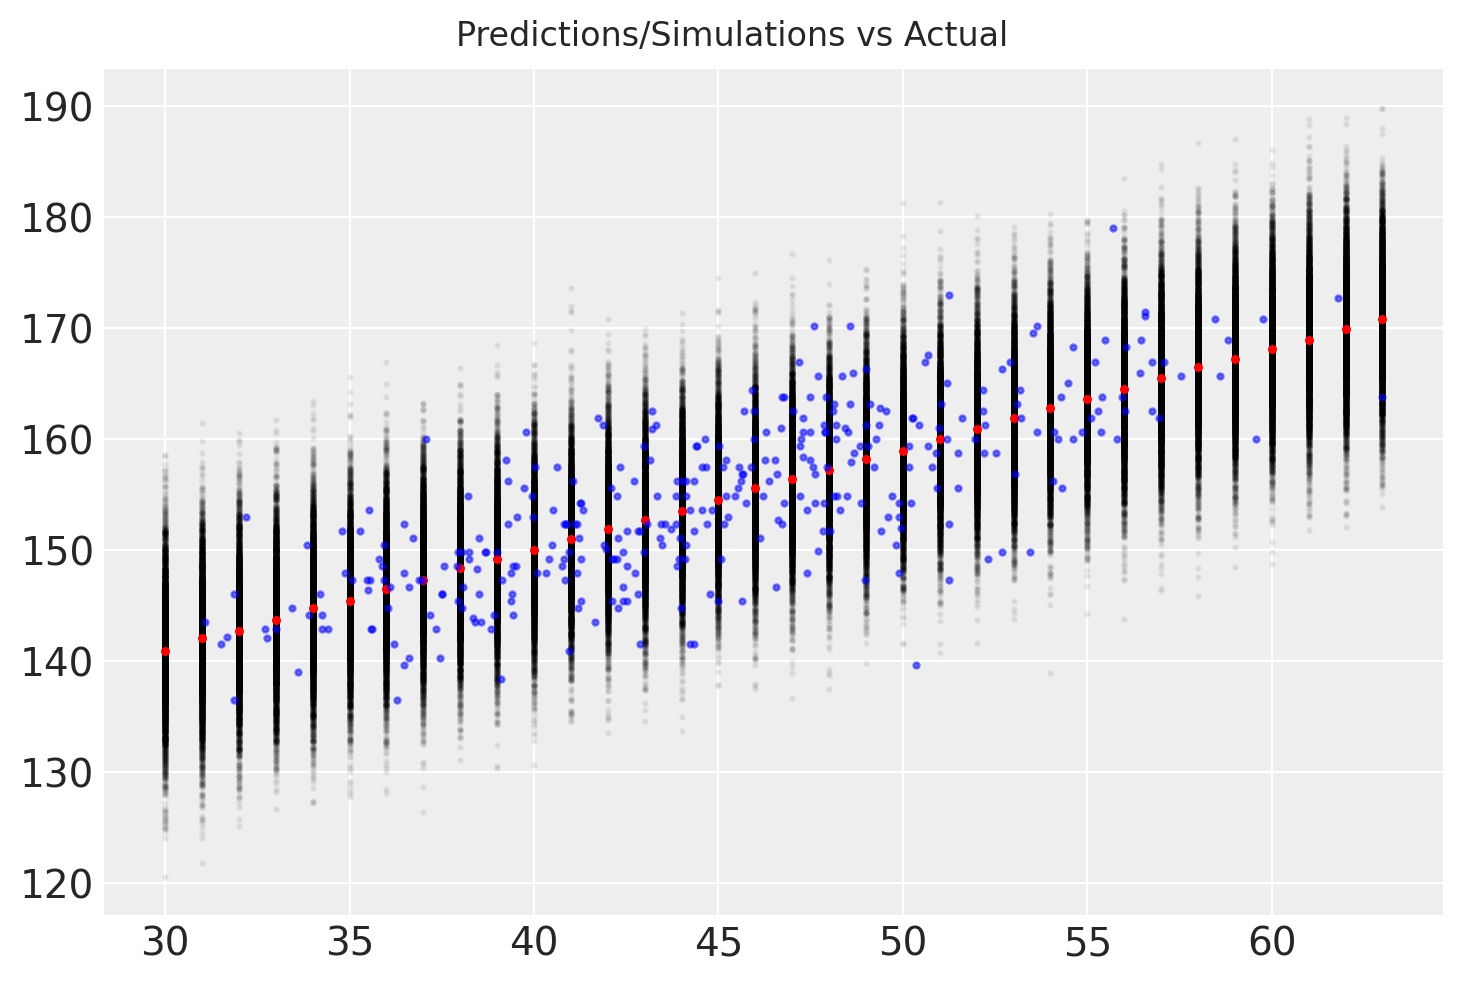

In [21]:
for index, value in enumerate(x):
    plt.scatter(
        np.repeat(value, prediction_sims.shape[1]),
        prediction_sims[index, :],
        color='black', alpha=0.05, s=2
    )
    plt.scatter(
        value,
        np.median(prediction_sims[index, :]),
        color='red', alpha=1, s=5,
    )
plt.scatter(
    d2.weight,
    d2.height,
    color='blue', alpha=0.5, s=4
);
plt.suptitle('Predictions/Simulations vs Actual')

Text(0.5, 0.98, 'Predictions/Simulations vs Actual')

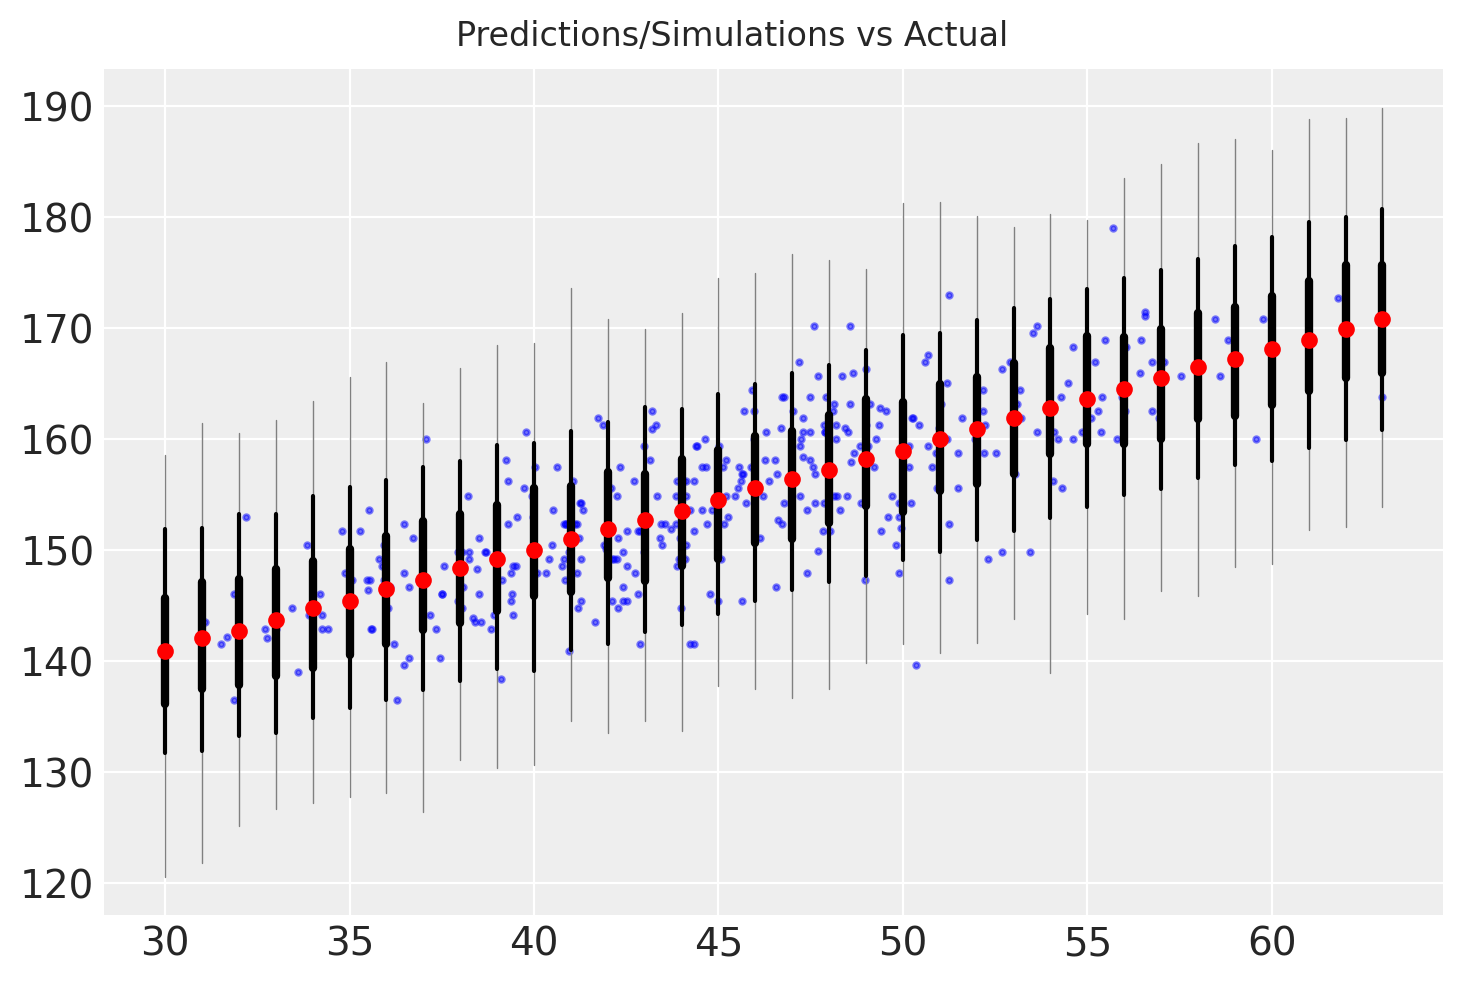

In [22]:
from helpsk.string import format_number

for index, value in enumerate(x):
    sims = prediction_sims[index, :]
    sim_min, sim_median, sim_max = np.quantile(sims, q=[0, 0.5, 1])
    sim_95_hdi_prob_low, sim_95_hdi_prob_hi = az.hdi(sims, hdi_prob=0.95)
    sim_66_hdi_prob_low, sim_66_hdi_prob_hi = az.hdi(sims, hdi_prob=0.66)
    

    plt.plot([value, value], [sim_min, sim_max], color='gray', linewidth=0.5)
    plt.plot([value, value], [sim_95_hdi_prob_low, sim_95_hdi_prob_hi], color='black', linewidth=1.5)
    plt.plot([value, value], [sim_66_hdi_prob_low, sim_66_hdi_prob_hi], color='black', linewidth=3)
    plt.plot(value, sim_median, 'o', markersize=5, color='red')

plt.scatter(
    d2.weight,
    d2.height,
    color='blue', alpha=0.5, s=4
);
plt.suptitle('Predictions/Simulations vs Actual')

---